# Image Caption Generator using LSTM and Bidirectional LSTM - MobileNet

"""
Copyright (c) 2018, by the Authors: Abhinav Tiwari, Ronak Mistry, Shivam Negi
This software is freely available under the MIT Public License. 
Please see the License file in the root for details.
""";

In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Reading from token file to extract captions

In [2]:
token = 'Flickr8k_text/Flickr8k.token.txt'


In [3]:
captions = open(token, 'r').read().strip().split('\n')

Preprocessing Images and captions

In [4]:
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
print(row[0])


# In[6]:



d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]
d  


# In[8]:


images = 'Flicker8k_Dataset/'


# In[9]:


# Contains all the images
img = glob.glob(images+'*.jpg')


# In[10]:


img[:5]


# In[126]:


train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'


# In[12]:


train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(train_images)                  


# In[13]:


def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp


# In[14]:


# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)


# In[15]:


val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_images


# In[16]:


# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)


# In[17]:


test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))


# In[18]:


# Getting the test images from all the images
test_img = split_data(test_images)
len(test_images)





997722733_0cb5439472.jpg
{'1417295167_5299df6db8.jpg', '2068403258_2669cf9763.jpg', '2959737718_31203fddb5.jpg', '3571039224_b34fa2f94c.jpg', '2834752476_3177e617f1.jpg', '2595713720_30534e8de2.jpg', '2866529477_7e0c053ebc.jpg', '1308617539_54e1a3dfbe.jpg', '539705321_99406e5820.jpg', '157139628_5dc483e2e4.jpg', '69710415_5c2bfb1058.jpg', '3627679667_0e3de9fc90.jpg', '2611651553_61f859837e.jpg', '241347114_6273736da8.jpg', '2193223202_4d908c0450.jpg', '3018467501_a03d404413.jpg', '109260216_85b0be5378.jpg', '541063419_a5f3672d59.jpg', '3518334317_bc40bae18d.jpg', '2191329761_3effd856c5.jpg', '3606846822_28c40b933a.jpg', '2752926645_801a198ff6.jpg', '47871819_db55ac4699.jpg', '3453313865_1ebff5393c.jpg', '428483413_b9370baf72.jpg', '2312984882_bec7849e09.jpg', '429205889_ff5a006311.jpg', '2718376488_3c62f7642c.jpg', '2467821766_0510c9a2d1.jpg', '3400082864_9c737c1450.jpg', '2174206711_11cb712a8d.jpg', '3632572264_577703b384.jpg', '2908859957_e96c33c1e0.jpg', '3139118874_599b30b116.jpg',

1000

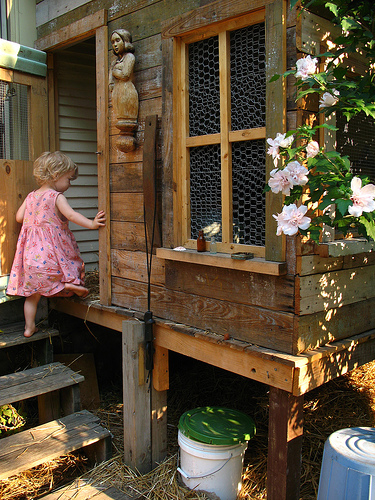

In [5]:
Image.open(train_img[0])

Changing image range to -1 to 1.

In [6]:

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

# Code and Config for MobileNet Model

We will feed the images to MobileNet to get the encoded images.
The last layer of MobileNet is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. We also need to perform average pooling.

This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(1024 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 1024).


In [7]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


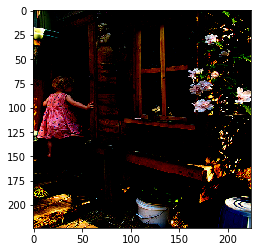

In [8]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [9]:
(preprocess(train_img[0])).shape

(1, 224, 224, 3)

In [10]:
np.squeeze(preprocess(train_img[0]))

array([[[-0.56078434, -0.5686275 , -0.42745095],
        [-0.16862744, -0.03529412, -0.08235294],
        [ 0.01176476,  0.1686275 ,  0.082353  ],
        ...,
        [-0.9607843 , -1.        , -0.96862745],
        [-0.9607843 , -0.9607843 , -0.9607843 ],
        [-0.9764706 , -0.9372549 , -0.9843137 ]],

       [[-0.6       , -0.62352943, -0.47450978],
        [-0.1372549 , -0.01176471, -0.01960784],
        [ 0.03529418,  0.20784318,  0.11372554],
        ...,
        [-0.92156863, -0.90588236, -0.92941177],
        [-0.94509804, -0.9372549 , -0.92156863],
        [-0.8352941 , -0.7647059 , -0.8980392 ]],

       [[-0.6313726 , -0.67058825, -0.4980392 ],
        [-0.10588235,  0.0196079 ,  0.0196079 ],
        [ 0.0196079 ,  0.20000005,  0.13725495],
        ...,
        [-0.9372549 , -0.92941177, -0.96862745],
        [-0.9843137 , -0.92941177, -0.9843137 ],
        [-1.        , -0.88235295, -0.9372549 ]],

       ...,

       [[ 0.8117647 ,  0.35686278, -0.40392154],
        [ 0

In [11]:
np.squeeze(preprocess(train_img[0])).shape


(224, 224, 3)

Feature extraction

In [12]:
from keras.applications.mobilenet import MobileNet
model = MobileNet(weights='imagenet')

17227776/17225924 [==============================] - ETA: 1: - ETA: 31s - ETA: 22 - ETA: 17 - ETA: 13 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 0us/step


The output of the model is in the shape (1, 1, 1, 1000). To get the expected output of (1, 1024), we remove the last layer and perform average pooling.

In [13]:
from keras.models import Model
new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

qwerty1 = model_new.predict(preprocess(train_img[0]))
qwerty1.shape

(1, 1, 1, 1000)

In [14]:
model_ch= MobileNet(input_shape=(224, 224,3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', input_tensor=None, pooling='avg')

17227776/17225924 [==============================] - ETA: 32 - ETA: 30 - ETA: 18 - ETA: 17 - ETA: 14 - ETA: 11 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 0us/step


In [15]:
dch = model_ch.predict(preprocess(train_img[0]))
dch.shape

(1, 1024)

Encoding train and test images

In [16]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_ch.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [31]:
encoding_train = {}
for img in tqdm(train_img):
   encoding_train[img[len(images):]] = encode(img)


with open("Mobilenet_encoded_images_training.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)







100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [05:20<00:00, 18.75it/s]


The code above can be commented once an encoded file has been generated. This saves time used by encoding.

In [32]:
with open('Mobilenet_encoded_images_training.p', 'rb') as b:
    encoding_train = pickle.load(b)

In [33]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(1024,)

In [34]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
    
with open("Mobilenet_encoded_images_test.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.37it/s]


The code above can be commented once an encoded file has been generated. This saves time used by encoding.

In [35]:
with open('Mobilenet_encoded_images_test.p', 'rb') as b:
    encoding_test = pickle.load(b)

In [36]:
encoding_test[test_img[0][len(images):]].shape


(1024,)

Defining dictionaries for test and train data where key is image name and values are the associated captions.

In [37]:

train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]


In [38]:

test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [39]:
len(train_img)

6000

In [40]:
len(test_d)

1000

In [41]:
len(train_d)

6000

### Calculating unique vocabulary

For word embedding and RNN model it very important to get the number of unique words in your vocabulary for the images to train and then predict outcome using the given set of vocab

In [42]:
#Define start and end flags
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [43]:

words = [i.split() for i in caps]
words = [i.split() for i in caps]
unique_mobile = []
for i in words:
    unique_mobile.extend(i)


Here we are adding start and end words to our vocab so that the model knows it has to start and end the prediction when it sees the words.
NOTE: start will indicate the model that it has to start predicting and end will indicate it to stop

In [44]:
unique_mobile = list(set(unique_mobile))

In [45]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique_mobile, pickle_d)

In [46]:

unique_mobile = pickle.load(open('unique.p', 'rb'))

The code above and below are used to save the various vocab in two forms:

1. A pickle file as it convenient and machine-readable, also can be used across platforms

2. A text file so that we humans can read it and be satisfied that the function we used has worked as we wanted it to!!

In [47]:
len(unique_mobile)

8256

As it can be seen above that our vocab has 8256 words in it. This is an important paramter for our model and will be used in the model later on

In [48]:
word2idx = {val:index for index, val in enumerate(unique_mobile)}

In [49]:
word2idx['<start>']


7007

In [50]:
idx2word = {index:val for index, val in enumerate(unique_mobile)}

In [51]:
idx2word[5553]

'row'

The maximum length of the sequence to generate, needed for padding inputs can be seen during model building phase

In [52]:

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [53]:

vocab_size = len(unique_mobile)
vocab_size

8256

In [54]:
f = open('Mobilenet_flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [55]:

for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [56]:
f1 = open('Mobilenet_flickr8k_test_dataset.txt', 'w')
f1.write("image_id\tcaptions\n")

for key, val in test_d.items():
    for i in val:
        f1.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f1.close()

df_test=pd.read_csv('Mobilenet_flickr8k_test_dataset.txt', delimiter='\t')

The train and test set are converted into df as can be shown below having columns("image_id" , "captions")

Start and end words are added before and after every caption for the model and data generator to understand as to when to initiate and when to terminate (Image below shows a snap of train data id and captions)

![title](./pics/img_cap.png)

In [57]:
df = pd.read_csv('Mobilenet_flickr8k_training_dataset.txt', delimiter='\t')

In [58]:

c = [i for i in df['captions']]
len(c)

30000

In [59]:
imgs = [i for i in df['image_id']]

In [60]:

a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [61]:

for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 7007
Woman => 3908
writing => 3004
on => 4250
a => 3408
pad => 1102
in => 8097
room => 3171
with => 7095
gold => 1864
, => 190
decorated => 3981
walls => 7928
. => 4525
<end> => 4201


Samples_per_epoch is an important parameter as it shows how many times the model has to iterate to complete one epoch.
This represents the captions multiplied by each word in every caption in training(i.e. the number of words that can be found in captions even counting repeated words)

In [62]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1
samples_per_epoch    

383454

# Generator

We will use the encoding of an image and use a start word to predict the next word. After that, we will again use the same image and use the predicted word to predict the next word. So, the image will be used at every iteration for the entire caption. This is how we will generate the caption for an image. Hence, we need to create a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept:https://youtu.be/cO0a0QYmFm8?t=32m25s

![title](./pics/Layers.png)

Image is a part of his lecture

In [63]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

### MobileNet Model with LSTM

1. The input size for this model is defined as 1024 because that is the vector size of the encoded training images above. They are processed by the dense layer to produce a 256 element representation of the photo. 
2. The embedding layer is for handling text input, followed by RNN(LSTM/BLSTM). The model expects input sequence with a predefined length which is the maximum length of the captions in the training dataset. This is defined as max_len.
3. The embedding size can be set to any value, however, based on trial and error, we found 300 to be an optimal value. The output size here is also 256.
4. The decoder model merges the vector from both the models using the add operation. Variable 'decoder1' is where both the models are added.
5. After the LSTM, the inputs are fed to a final dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

![title](./pics/Schematic-of-the-Merge-Model-For-Image-Captioning.png)

In [64]:
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Add
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add


# define the captioning model
def define_model(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(1024,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256 , return_sequences= True)(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    decoder1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(decoder1)
    se5 = LSTM(256, return_sequences= True)(se4)
    se6 = LSTM(256)(se5)
    decoder2 = Dense(256, activation='relu')(se6)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model


In [65]:
Mobilenet_lstm_model = define_model(8256,40)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 40, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 

Through trial and error, it was observed that increasing the batch size, the training time and the loss wereboth reduced. However the memory limits on the machine limit us from going beyond 512. Also, a high batch_size means the model does not generalize well.

In [66]:
batch_size = 512

Mobilenet_lstm_model.fit_generator(data_generator(batch_size), samples_per_epoch=(samples_per_epoch/batch_size), epochs=15, 
                          verbose=1)

D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=15, verbose=1, steps_per_epoch=748.933593...)`
  after removing the cwd from sys.path.


Epoch 1/15


204/748 [=======>......................] - ETA: 1:27:55 - loss: 9.0188 - acc: 0.0000e+ - ETA: 55:16 - loss: 8.9370 - acc: 0.0547     - ETA: 44:10 - loss: 8.5825 - acc: 0.06 - ETA: 38:37 - loss: 7.9895 - acc: 0.06 - ETA: 35:17 - loss: 7.5845 - acc: 0.07 - ETA: 33:14 - loss: 7.3179 - acc: 0.07 - ETA: 31:45 - loss: 7.0973 - acc: 0.07 - ETA: 30:34 - loss: 6.9149 - acc: 0.07 - ETA: 29:36 - loss: 6.7880 - acc: 0.07 - ETA: 28:50 - loss: 6.6931 - acc: 0.07 - ETA: 28:10 - loss: 6.6251 - acc: 0.07 - ETA: 27:38 - loss: 6.5279 - acc: 0.07 - ETA: 27:08 - loss: 6.4569 - acc: 0.07 - ETA: 26:45 - loss: 6.4053 - acc: 0.07 - ETA: 26:23 - loss: 6.3552 - acc: 0.07 - ETA: 26:05 - loss: 6.3030 - acc: 0.08 - ETA: 25:49 - loss: 6.2486 - acc: 0.08 - ETA: 25:33 - loss: 6.1989 - acc: 0.09 - ETA: 25:20 - loss: 6.1561 - acc: 0.09 - ETA: 25:08 - loss: 6.1227 - acc: 0.09 - ETA: 24:56 - loss: 6.1028 - acc: 0.09 - ETA: 24:47 - loss: 6.0737 - acc: 0.09 - ETA: 24:37 - loss: 6.0429 - acc: 0.10 - ETA: 24:28 - loss: 6.0173

612/748 [=======================>......] - ETA: 10:27 - loss: 4.6137 - acc: 0.23 - ETA: 10:25 - loss: 4.6120 - acc: 0.23 - ETA: 10:23 - loss: 4.6105 - acc: 0.23 - ETA: 10:21 - loss: 4.6085 - acc: 0.23 - ETA: 10:19 - loss: 4.6073 - acc: 0.23 - ETA: 10:18 - loss: 4.6059 - acc: 0.23 - ETA: 10:16 - loss: 4.6044 - acc: 0.23 - ETA: 10:14 - loss: 4.6029 - acc: 0.23 - ETA: 10:12 - loss: 4.6008 - acc: 0.23 - ETA: 10:10 - loss: 4.5991 - acc: 0.23 - ETA: 10:08 - loss: 4.5977 - acc: 0.23 - ETA: 10:07 - loss: 4.5953 - acc: 0.23 - ETA: 10:05 - loss: 4.5943 - acc: 0.23 - ETA: 10:03 - loss: 4.5924 - acc: 0.23 - ETA: 10:01 - loss: 4.5906 - acc: 0.23 - ETA: 9:59 - loss: 4.5892 - acc: 0.2399 - ETA: 9:58 - loss: 4.5883 - acc: 0.240 - ETA: 9:56 - loss: 4.5867 - acc: 0.240 - ETA: 9:54 - loss: 4.5850 - acc: 0.240 - ETA: 9:52 - loss: 4.5832 - acc: 0.240 - ETA: 9:50 - loss: 4.5817 - acc: 0.241 - ETA: 9:49 - loss: 4.5798 - acc: 0.241 - ETA: 9:47 - loss: 4.5774 - acc: 0.241 - ETA: 9:45 - loss: 4.5766 - acc: 0.24

749/748 [==============================] - ETA: 4:12 - loss: 4.3520 - acc: 0.267 - ETA: 4:10 - loss: 4.3509 - acc: 0.267 - ETA: 4:08 - loss: 4.3497 - acc: 0.268 - ETA: 4:06 - loss: 4.3487 - acc: 0.268 - ETA: 4:04 - loss: 4.3478 - acc: 0.268 - ETA: 4:03 - loss: 4.3467 - acc: 0.268 - ETA: 4:01 - loss: 4.3460 - acc: 0.268 - ETA: 3:59 - loss: 4.3452 - acc: 0.268 - ETA: 3:57 - loss: 4.3446 - acc: 0.268 - ETA: 3:55 - loss: 4.3435 - acc: 0.268 - ETA: 3:53 - loss: 4.3426 - acc: 0.268 - ETA: 3:51 - loss: 4.3411 - acc: 0.269 - ETA: 3:50 - loss: 4.3398 - acc: 0.269 - ETA: 3:48 - loss: 4.3386 - acc: 0.269 - ETA: 3:46 - loss: 4.3371 - acc: 0.269 - ETA: 3:44 - loss: 4.3357 - acc: 0.269 - ETA: 3:42 - loss: 4.3345 - acc: 0.269 - ETA: 3:40 - loss: 4.3332 - acc: 0.269 - ETA: 3:38 - loss: 4.3323 - acc: 0.269 - ETA: 3:37 - loss: 4.3311 - acc: 0.270 - ETA: 3:35 - loss: 4.3301 - acc: 0.270 - ETA: 3:33 - loss: 4.3293 - acc: 0.270 - ETA: 3:31 - loss: 4.3285 - acc: 0.270 - ETA: 3:29 - loss: 4.3277 - acc: 0.270

204/748 [=======>......................] - ETA: 24:31 - loss: 3.9948 - acc: 0.32 - ETA: 24:25 - loss: 3.7771 - acc: 0.33 - ETA: 24:03 - loss: 3.7108 - acc: 0.35 - ETA: 23:52 - loss: 3.7030 - acc: 0.34 - ETA: 23:44 - loss: 3.6530 - acc: 0.35 - ETA: 23:35 - loss: 3.6318 - acc: 0.35 - ETA: 23:31 - loss: 3.6249 - acc: 0.34 - ETA: 23:26 - loss: 3.6041 - acc: 0.35 - ETA: 23:29 - loss: 3.6291 - acc: 0.35 - ETA: 23:24 - loss: 3.6664 - acc: 0.34 - ETA: 23:17 - loss: 3.6848 - acc: 0.34 - ETA: 23:11 - loss: 3.6667 - acc: 0.34 - ETA: 23:06 - loss: 3.6624 - acc: 0.34 - ETA: 23:02 - loss: 3.6628 - acc: 0.34 - ETA: 22:58 - loss: 3.6572 - acc: 0.34 - ETA: 22:55 - loss: 3.6570 - acc: 0.34 - ETA: 22:53 - loss: 3.6564 - acc: 0.34 - ETA: 22:50 - loss: 3.6464 - acc: 0.34 - ETA: 22:47 - loss: 3.6344 - acc: 0.34 - ETA: 22:44 - loss: 3.6335 - acc: 0.34 - ETA: 22:41 - loss: 3.6446 - acc: 0.34 - ETA: 22:38 - loss: 3.6469 - acc: 0.34 - ETA: 22:36 - loss: 3.6374 - acc: 0.34 - ETA: 22:33 - loss: 3.6421 - acc: 0.34

612/748 [=======================>......] - ETA: 10:47 - loss: 3.5456 - acc: 0.35 - ETA: 10:45 - loss: 3.5455 - acc: 0.35 - ETA: 10:43 - loss: 3.5453 - acc: 0.35 - ETA: 10:41 - loss: 3.5448 - acc: 0.35 - ETA: 10:39 - loss: 3.5450 - acc: 0.35 - ETA: 10:37 - loss: 3.5449 - acc: 0.35 - ETA: 10:35 - loss: 3.5449 - acc: 0.35 - ETA: 10:33 - loss: 3.5450 - acc: 0.35 - ETA: 10:31 - loss: 3.5440 - acc: 0.35 - ETA: 10:29 - loss: 3.5439 - acc: 0.35 - ETA: 10:27 - loss: 3.5436 - acc: 0.35 - ETA: 10:25 - loss: 3.5426 - acc: 0.35 - ETA: 10:23 - loss: 3.5428 - acc: 0.35 - ETA: 10:21 - loss: 3.5428 - acc: 0.35 - ETA: 10:19 - loss: 3.5423 - acc: 0.35 - ETA: 10:17 - loss: 3.5424 - acc: 0.35 - ETA: 10:15 - loss: 3.5427 - acc: 0.35 - ETA: 10:13 - loss: 3.5425 - acc: 0.35 - ETA: 10:12 - loss: 3.5424 - acc: 0.35 - ETA: 10:10 - loss: 3.5418 - acc: 0.35 - ETA: 10:08 - loss: 3.5415 - acc: 0.35 - ETA: 10:06 - loss: 3.5410 - acc: 0.35 - ETA: 10:04 - loss: 3.5403 - acc: 0.35 - ETA: 10:02 - loss: 3.5405 - acc: 0.35

749/748 [==============================] - ETA: 4:15 - loss: 3.5047 - acc: 0.356 - ETA: 4:13 - loss: 3.5042 - acc: 0.356 - ETA: 4:12 - loss: 3.5039 - acc: 0.356 - ETA: 4:10 - loss: 3.5038 - acc: 0.356 - ETA: 4:08 - loss: 3.5037 - acc: 0.356 - ETA: 4:06 - loss: 3.5032 - acc: 0.356 - ETA: 4:04 - loss: 3.5034 - acc: 0.356 - ETA: 4:02 - loss: 3.5033 - acc: 0.356 - ETA: 4:00 - loss: 3.5034 - acc: 0.356 - ETA: 3:58 - loss: 3.5033 - acc: 0.356 - ETA: 3:56 - loss: 3.5030 - acc: 0.356 - ETA: 3:55 - loss: 3.5023 - acc: 0.356 - ETA: 3:53 - loss: 3.5018 - acc: 0.356 - ETA: 3:51 - loss: 3.5014 - acc: 0.356 - ETA: 3:49 - loss: 3.5008 - acc: 0.356 - ETA: 3:47 - loss: 3.5004 - acc: 0.356 - ETA: 3:45 - loss: 3.4999 - acc: 0.357 - ETA: 3:43 - loss: 3.4996 - acc: 0.357 - ETA: 3:41 - loss: 3.4994 - acc: 0.357 - ETA: 3:39 - loss: 3.4992 - acc: 0.357 - ETA: 3:38 - loss: 3.4989 - acc: 0.357 - ETA: 3:36 - loss: 3.4989 - acc: 0.357 - ETA: 3:34 - loss: 3.4990 - acc: 0.357 - ETA: 3:32 - loss: 3.4989 - acc: 0.357

204/748 [=======>......................] - ETA: 22:54 - loss: 3.7189 - acc: 0.36 - ETA: 22:49 - loss: 3.5139 - acc: 0.36 - ETA: 22:46 - loss: 3.4297 - acc: 0.38 - ETA: 22:51 - loss: 3.3981 - acc: 0.37 - ETA: 22:49 - loss: 3.3813 - acc: 0.37 - ETA: 22:47 - loss: 3.3502 - acc: 0.37 - ETA: 22:45 - loss: 3.3402 - acc: 0.37 - ETA: 22:45 - loss: 3.3204 - acc: 0.37 - ETA: 22:40 - loss: 3.3408 - acc: 0.37 - ETA: 22:36 - loss: 3.3789 - acc: 0.37 - ETA: 22:33 - loss: 3.3883 - acc: 0.37 - ETA: 22:31 - loss: 3.3752 - acc: 0.37 - ETA: 22:29 - loss: 3.3723 - acc: 0.37 - ETA: 22:27 - loss: 3.3716 - acc: 0.37 - ETA: 22:24 - loss: 3.3686 - acc: 0.37 - ETA: 22:23 - loss: 3.3731 - acc: 0.37 - ETA: 22:21 - loss: 3.3713 - acc: 0.37 - ETA: 22:19 - loss: 3.3648 - acc: 0.37 - ETA: 22:17 - loss: 3.3580 - acc: 0.37 - ETA: 22:15 - loss: 3.3607 - acc: 0.37 - ETA: 22:13 - loss: 3.3680 - acc: 0.37 - ETA: 22:12 - loss: 3.3728 - acc: 0.37 - ETA: 22:10 - loss: 3.3617 - acc: 0.37 - ETA: 22:07 - loss: 3.3659 - acc: 0.37

612/748 [=======================>......] - ETA: 10:39 - loss: 3.3150 - acc: 0.37 - ETA: 10:37 - loss: 3.3152 - acc: 0.37 - ETA: 10:35 - loss: 3.3150 - acc: 0.37 - ETA: 10:34 - loss: 3.3148 - acc: 0.37 - ETA: 10:32 - loss: 3.3149 - acc: 0.37 - ETA: 10:30 - loss: 3.3149 - acc: 0.37 - ETA: 10:28 - loss: 3.3151 - acc: 0.37 - ETA: 10:26 - loss: 3.3152 - acc: 0.37 - ETA: 10:24 - loss: 3.3144 - acc: 0.37 - ETA: 10:23 - loss: 3.3146 - acc: 0.37 - ETA: 10:21 - loss: 3.3144 - acc: 0.37 - ETA: 10:19 - loss: 3.3136 - acc: 0.37 - ETA: 10:17 - loss: 3.3139 - acc: 0.37 - ETA: 10:15 - loss: 3.3138 - acc: 0.37 - ETA: 10:13 - loss: 3.3137 - acc: 0.37 - ETA: 10:11 - loss: 3.3138 - acc: 0.37 - ETA: 10:10 - loss: 3.3141 - acc: 0.37 - ETA: 10:08 - loss: 3.3141 - acc: 0.37 - ETA: 10:06 - loss: 3.3140 - acc: 0.37 - ETA: 10:04 - loss: 3.3135 - acc: 0.37 - ETA: 10:02 - loss: 3.3134 - acc: 0.37 - ETA: 10:00 - loss: 3.3130 - acc: 0.37 - ETA: 9:59 - loss: 3.3125 - acc: 0.3753 - ETA: 9:57 - loss: 3.3131 - acc: 0.37

749/748 [==============================] - ETA: 4:18 - loss: 3.2946 - acc: 0.377 - ETA: 4:16 - loss: 3.2944 - acc: 0.377 - ETA: 4:14 - loss: 3.2941 - acc: 0.377 - ETA: 4:12 - loss: 3.2940 - acc: 0.377 - ETA: 4:11 - loss: 3.2938 - acc: 0.377 - ETA: 4:09 - loss: 3.2935 - acc: 0.377 - ETA: 4:07 - loss: 3.2937 - acc: 0.377 - ETA: 4:05 - loss: 3.2936 - acc: 0.377 - ETA: 4:03 - loss: 3.2939 - acc: 0.377 - ETA: 4:01 - loss: 3.2937 - acc: 0.377 - ETA: 3:59 - loss: 3.2935 - acc: 0.377 - ETA: 3:57 - loss: 3.2929 - acc: 0.377 - ETA: 3:55 - loss: 3.2927 - acc: 0.377 - ETA: 3:54 - loss: 3.2922 - acc: 0.377 - ETA: 3:52 - loss: 3.2917 - acc: 0.377 - ETA: 3:50 - loss: 3.2914 - acc: 0.377 - ETA: 3:48 - loss: 3.2908 - acc: 0.377 - ETA: 3:46 - loss: 3.2907 - acc: 0.377 - ETA: 3:44 - loss: 3.2906 - acc: 0.377 - ETA: 3:42 - loss: 3.2904 - acc: 0.377 - ETA: 3:40 - loss: 3.2904 - acc: 0.377 - ETA: 3:38 - loss: 3.2902 - acc: 0.377 - ETA: 3:36 - loss: 3.2906 - acc: 0.377 - ETA: 3:35 - loss: 3.2906 - acc: 0.377

204/748 [=======>......................] - ETA: 23:50 - loss: 3.5702 - acc: 0.37 - ETA: 24:01 - loss: 3.3028 - acc: 0.39 - ETA: 23:53 - loss: 3.2697 - acc: 0.39 - ETA: 23:48 - loss: 3.2174 - acc: 0.39 - ETA: 23:46 - loss: 3.2163 - acc: 0.39 - ETA: 23:46 - loss: 3.1840 - acc: 0.39 - ETA: 23:54 - loss: 3.1812 - acc: 0.39 - ETA: 23:57 - loss: 3.1606 - acc: 0.39 - ETA: 24:03 - loss: 3.1895 - acc: 0.39 - ETA: 24:04 - loss: 3.2309 - acc: 0.39 - ETA: 24:03 - loss: 3.2318 - acc: 0.38 - ETA: 24:01 - loss: 3.2266 - acc: 0.38 - ETA: 24:01 - loss: 3.2162 - acc: 0.38 - ETA: 24:00 - loss: 3.2256 - acc: 0.38 - ETA: 23:58 - loss: 3.2199 - acc: 0.38 - ETA: 23:57 - loss: 3.2245 - acc: 0.38 - ETA: 23:54 - loss: 3.2261 - acc: 0.38 - ETA: 23:49 - loss: 3.2211 - acc: 0.38 - ETA: 23:45 - loss: 3.2144 - acc: 0.38 - ETA: 23:42 - loss: 3.2198 - acc: 0.38 - ETA: 23:38 - loss: 3.2267 - acc: 0.38 - ETA: 23:34 - loss: 3.2357 - acc: 0.38 - ETA: 23:31 - loss: 3.2227 - acc: 0.38 - ETA: 23:29 - loss: 3.2268 - acc: 0.38

612/748 [=======================>......] - ETA: 10:59 - loss: 3.1894 - acc: 0.38 - ETA: 10:57 - loss: 3.1898 - acc: 0.38 - ETA: 10:55 - loss: 3.1895 - acc: 0.38 - ETA: 10:54 - loss: 3.1895 - acc: 0.38 - ETA: 10:52 - loss: 3.1897 - acc: 0.38 - ETA: 10:50 - loss: 3.1898 - acc: 0.38 - ETA: 10:48 - loss: 3.1899 - acc: 0.38 - ETA: 10:46 - loss: 3.1900 - acc: 0.38 - ETA: 10:44 - loss: 3.1891 - acc: 0.38 - ETA: 10:42 - loss: 3.1894 - acc: 0.38 - ETA: 10:40 - loss: 3.1889 - acc: 0.38 - ETA: 10:38 - loss: 3.1885 - acc: 0.38 - ETA: 10:36 - loss: 3.1887 - acc: 0.38 - ETA: 10:34 - loss: 3.1886 - acc: 0.38 - ETA: 10:32 - loss: 3.1885 - acc: 0.38 - ETA: 10:30 - loss: 3.1888 - acc: 0.38 - ETA: 10:28 - loss: 3.1891 - acc: 0.38 - ETA: 10:26 - loss: 3.1892 - acc: 0.38 - ETA: 10:24 - loss: 3.1891 - acc: 0.38 - ETA: 10:22 - loss: 3.1886 - acc: 0.38 - ETA: 10:20 - loss: 3.1888 - acc: 0.38 - ETA: 10:19 - loss: 3.1883 - acc: 0.38 - ETA: 10:17 - loss: 3.1880 - acc: 0.38 - ETA: 10:15 - loss: 3.1886 - acc: 0.38

749/748 [==============================] - ETA: 4:23 - loss: 3.1770 - acc: 0.389 - ETA: 4:21 - loss: 3.1768 - acc: 0.389 - ETA: 4:19 - loss: 3.1766 - acc: 0.389 - ETA: 4:17 - loss: 3.1764 - acc: 0.389 - ETA: 4:15 - loss: 3.1764 - acc: 0.389 - ETA: 4:13 - loss: 3.1762 - acc: 0.389 - ETA: 4:11 - loss: 3.1763 - acc: 0.389 - ETA: 4:10 - loss: 3.1763 - acc: 0.389 - ETA: 4:08 - loss: 3.1765 - acc: 0.389 - ETA: 4:06 - loss: 3.1765 - acc: 0.389 - ETA: 4:04 - loss: 3.1761 - acc: 0.389 - ETA: 4:02 - loss: 3.1755 - acc: 0.389 - ETA: 4:00 - loss: 3.1753 - acc: 0.389 - ETA: 3:58 - loss: 3.1749 - acc: 0.389 - ETA: 3:56 - loss: 3.1745 - acc: 0.389 - ETA: 3:54 - loss: 3.1741 - acc: 0.389 - ETA: 3:52 - loss: 3.1736 - acc: 0.389 - ETA: 3:50 - loss: 3.1736 - acc: 0.389 - ETA: 3:48 - loss: 3.1734 - acc: 0.389 - ETA: 3:46 - loss: 3.1734 - acc: 0.389 - ETA: 3:44 - loss: 3.1735 - acc: 0.389 - ETA: 3:42 - loss: 3.1732 - acc: 0.389 - ETA: 3:40 - loss: 3.1736 - acc: 0.389 - ETA: 3:39 - loss: 3.1735 - acc: 0.389

204/748 [=======>......................] - ETA: 23:55 - loss: 3.4744 - acc: 0.37 - ETA: 23:53 - loss: 3.1656 - acc: 0.39 - ETA: 23:48 - loss: 3.1727 - acc: 0.39 - ETA: 23:48 - loss: 3.1218 - acc: 0.39 - ETA: 23:48 - loss: 3.1038 - acc: 0.40 - ETA: 23:45 - loss: 3.0887 - acc: 0.40 - ETA: 23:41 - loss: 3.0721 - acc: 0.40 - ETA: 23:41 - loss: 3.0565 - acc: 0.40 - ETA: 23:42 - loss: 3.0997 - acc: 0.40 - ETA: 23:42 - loss: 3.1328 - acc: 0.40 - ETA: 23:39 - loss: 3.1338 - acc: 0.39 - ETA: 23:37 - loss: 3.1349 - acc: 0.39 - ETA: 23:37 - loss: 3.1301 - acc: 0.39 - ETA: 23:34 - loss: 3.1455 - acc: 0.39 - ETA: 23:33 - loss: 3.1367 - acc: 0.39 - ETA: 23:30 - loss: 3.1405 - acc: 0.39 - ETA: 23:27 - loss: 3.1391 - acc: 0.39 - ETA: 23:24 - loss: 3.1376 - acc: 0.39 - ETA: 23:22 - loss: 3.1321 - acc: 0.39 - ETA: 23:20 - loss: 3.1365 - acc: 0.39 - ETA: 23:19 - loss: 3.1419 - acc: 0.39 - ETA: 23:16 - loss: 3.1472 - acc: 0.39 - ETA: 23:16 - loss: 3.1399 - acc: 0.39 - ETA: 23:14 - loss: 3.1400 - acc: 0.39

612/748 [=======================>......] - ETA: 10:58 - loss: 3.1084 - acc: 0.39 - ETA: 10:56 - loss: 3.1085 - acc: 0.39 - ETA: 10:54 - loss: 3.1086 - acc: 0.39 - ETA: 10:52 - loss: 3.1082 - acc: 0.39 - ETA: 10:50 - loss: 3.1087 - acc: 0.39 - ETA: 10:49 - loss: 3.1088 - acc: 0.39 - ETA: 10:47 - loss: 3.1089 - acc: 0.39 - ETA: 10:45 - loss: 3.1089 - acc: 0.39 - ETA: 10:43 - loss: 3.1083 - acc: 0.39 - ETA: 10:41 - loss: 3.1085 - acc: 0.39 - ETA: 10:39 - loss: 3.1077 - acc: 0.39 - ETA: 10:37 - loss: 3.1074 - acc: 0.39 - ETA: 10:35 - loss: 3.1075 - acc: 0.39 - ETA: 10:33 - loss: 3.1074 - acc: 0.39 - ETA: 10:31 - loss: 3.1074 - acc: 0.39 - ETA: 10:29 - loss: 3.1078 - acc: 0.39 - ETA: 10:27 - loss: 3.1080 - acc: 0.39 - ETA: 10:25 - loss: 3.1083 - acc: 0.39 - ETA: 10:23 - loss: 3.1080 - acc: 0.39 - ETA: 10:21 - loss: 3.1080 - acc: 0.39 - ETA: 10:19 - loss: 3.1078 - acc: 0.39 - ETA: 10:17 - loss: 3.1074 - acc: 0.39 - ETA: 10:15 - loss: 3.1073 - acc: 0.39 - ETA: 10:14 - loss: 3.1079 - acc: 0.39

749/748 [==============================] - ETA: 4:22 - loss: 3.0987 - acc: 0.399 - ETA: 4:20 - loss: 3.0986 - acc: 0.399 - ETA: 4:18 - loss: 3.0986 - acc: 0.399 - ETA: 4:16 - loss: 3.0983 - acc: 0.399 - ETA: 4:14 - loss: 3.0982 - acc: 0.399 - ETA: 4:12 - loss: 3.0982 - acc: 0.399 - ETA: 4:10 - loss: 3.0982 - acc: 0.399 - ETA: 4:08 - loss: 3.0982 - acc: 0.399 - ETA: 4:06 - loss: 3.0985 - acc: 0.399 - ETA: 4:04 - loss: 3.0984 - acc: 0.399 - ETA: 4:02 - loss: 3.0981 - acc: 0.399 - ETA: 4:00 - loss: 3.0975 - acc: 0.399 - ETA: 3:58 - loss: 3.0974 - acc: 0.399 - ETA: 3:56 - loss: 3.0970 - acc: 0.399 - ETA: 3:55 - loss: 3.0966 - acc: 0.399 - ETA: 3:53 - loss: 3.0962 - acc: 0.399 - ETA: 3:51 - loss: 3.0958 - acc: 0.399 - ETA: 3:49 - loss: 3.0958 - acc: 0.399 - ETA: 3:47 - loss: 3.0957 - acc: 0.399 - ETA: 3:45 - loss: 3.0957 - acc: 0.399 - ETA: 3:43 - loss: 3.0958 - acc: 0.399 - ETA: 3:41 - loss: 3.0956 - acc: 0.399 - ETA: 3:39 - loss: 3.0960 - acc: 0.399 - ETA: 3:37 - loss: 3.0957 - acc: 0.399

204/748 [=======>......................] - ETA: 22:59 - loss: 3.2694 - acc: 0.39 - ETA: 23:05 - loss: 3.0815 - acc: 0.40 - ETA: 23:02 - loss: 3.0688 - acc: 0.40 - ETA: 23:02 - loss: 3.0319 - acc: 0.41 - ETA: 22:59 - loss: 3.0262 - acc: 0.41 - ETA: 22:55 - loss: 3.0138 - acc: 0.41 - ETA: 22:50 - loss: 2.9937 - acc: 0.41 - ETA: 22:49 - loss: 2.9873 - acc: 0.41 - ETA: 22:48 - loss: 3.0383 - acc: 0.40 - ETA: 22:46 - loss: 3.0675 - acc: 0.40 - ETA: 22:44 - loss: 3.0580 - acc: 0.40 - ETA: 22:38 - loss: 3.0558 - acc: 0.40 - ETA: 22:40 - loss: 3.0588 - acc: 0.40 - ETA: 22:38 - loss: 3.0726 - acc: 0.40 - ETA: 22:39 - loss: 3.0594 - acc: 0.40 - ETA: 22:39 - loss: 3.0631 - acc: 0.40 - ETA: 22:37 - loss: 3.0641 - acc: 0.40 - ETA: 22:35 - loss: 3.0617 - acc: 0.40 - ETA: 22:31 - loss: 3.0600 - acc: 0.40 - ETA: 22:29 - loss: 3.0662 - acc: 0.40 - ETA: 22:26 - loss: 3.0722 - acc: 0.40 - ETA: 22:23 - loss: 3.0721 - acc: 0.40 - ETA: 22:21 - loss: 3.0691 - acc: 0.40 - ETA: 22:19 - loss: 3.0671 - acc: 0.40

612/748 [=======================>......] - ETA: 10:36 - loss: 3.0466 - acc: 0.40 - ETA: 10:34 - loss: 3.0468 - acc: 0.40 - ETA: 10:33 - loss: 3.0467 - acc: 0.40 - ETA: 10:31 - loss: 3.0464 - acc: 0.40 - ETA: 10:29 - loss: 3.0470 - acc: 0.40 - ETA: 10:27 - loss: 3.0471 - acc: 0.40 - ETA: 10:25 - loss: 3.0471 - acc: 0.40 - ETA: 10:23 - loss: 3.0470 - acc: 0.40 - ETA: 10:22 - loss: 3.0466 - acc: 0.40 - ETA: 10:20 - loss: 3.0469 - acc: 0.40 - ETA: 10:18 - loss: 3.0462 - acc: 0.40 - ETA: 10:16 - loss: 3.0462 - acc: 0.40 - ETA: 10:14 - loss: 3.0461 - acc: 0.40 - ETA: 10:12 - loss: 3.0459 - acc: 0.40 - ETA: 10:11 - loss: 3.0459 - acc: 0.40 - ETA: 10:09 - loss: 3.0463 - acc: 0.40 - ETA: 10:07 - loss: 3.0466 - acc: 0.40 - ETA: 10:05 - loss: 3.0466 - acc: 0.40 - ETA: 10:03 - loss: 3.0465 - acc: 0.40 - ETA: 10:01 - loss: 3.0465 - acc: 0.40 - ETA: 10:00 - loss: 3.0464 - acc: 0.40 - ETA: 9:58 - loss: 3.0460 - acc: 0.4046 - ETA: 9:56 - loss: 3.0458 - acc: 0.404 - ETA: 9:54 - loss: 3.0465 - acc: 0.40

749/748 [==============================] - ETA: 4:18 - loss: 3.0391 - acc: 0.405 - ETA: 4:16 - loss: 3.0390 - acc: 0.405 - ETA: 4:14 - loss: 3.0391 - acc: 0.405 - ETA: 4:12 - loss: 3.0388 - acc: 0.405 - ETA: 4:10 - loss: 3.0386 - acc: 0.405 - ETA: 4:08 - loss: 3.0386 - acc: 0.405 - ETA: 4:06 - loss: 3.0386 - acc: 0.405 - ETA: 4:04 - loss: 3.0385 - acc: 0.405 - ETA: 4:03 - loss: 3.0389 - acc: 0.405 - ETA: 4:01 - loss: 3.0388 - acc: 0.405 - ETA: 3:59 - loss: 3.0384 - acc: 0.405 - ETA: 3:57 - loss: 3.0379 - acc: 0.405 - ETA: 3:55 - loss: 3.0378 - acc: 0.405 - ETA: 3:53 - loss: 3.0374 - acc: 0.405 - ETA: 3:51 - loss: 3.0372 - acc: 0.405 - ETA: 3:50 - loss: 3.0367 - acc: 0.405 - ETA: 3:48 - loss: 3.0363 - acc: 0.405 - ETA: 3:46 - loss: 3.0362 - acc: 0.405 - ETA: 3:44 - loss: 3.0361 - acc: 0.405 - ETA: 3:42 - loss: 3.0362 - acc: 0.405 - ETA: 3:40 - loss: 3.0361 - acc: 0.405 - ETA: 3:38 - loss: 3.0361 - acc: 0.405 - ETA: 3:36 - loss: 3.0366 - acc: 0.405 - ETA: 3:34 - loss: 3.0362 - acc: 0.405

204/748 [=======>......................] - ETA: 24:36 - loss: 3.1906 - acc: 0.39 - ETA: 24:23 - loss: 3.0061 - acc: 0.41 - ETA: 24:19 - loss: 2.9961 - acc: 0.41 - ETA: 24:12 - loss: 2.9868 - acc: 0.41 - ETA: 24:08 - loss: 2.9511 - acc: 0.42 - ETA: 24:04 - loss: 2.9422 - acc: 0.41 - ETA: 23:59 - loss: 2.9213 - acc: 0.42 - ETA: 23:55 - loss: 2.9408 - acc: 0.42 - ETA: 23:51 - loss: 2.9810 - acc: 0.41 - ETA: 23:47 - loss: 3.0046 - acc: 0.41 - ETA: 23:45 - loss: 3.0003 - acc: 0.41 - ETA: 23:47 - loss: 2.9972 - acc: 0.41 - ETA: 23:46 - loss: 3.0033 - acc: 0.41 - ETA: 23:47 - loss: 3.0197 - acc: 0.41 - ETA: 23:47 - loss: 3.0035 - acc: 0.41 - ETA: 23:44 - loss: 3.0099 - acc: 0.41 - ETA: 23:42 - loss: 3.0132 - acc: 0.40 - ETA: 23:41 - loss: 3.0103 - acc: 0.41 - ETA: 23:40 - loss: 3.0061 - acc: 0.41 - ETA: 23:39 - loss: 3.0156 - acc: 0.40 - ETA: 23:36 - loss: 3.0198 - acc: 0.40 - ETA: 23:33 - loss: 3.0220 - acc: 0.40 - ETA: 23:30 - loss: 3.0157 - acc: 0.40 - ETA: 23:28 - loss: 3.0103 - acc: 0.40

612/748 [=======================>......] - ETA: 11:09 - loss: 2.9985 - acc: 0.41 - ETA: 11:07 - loss: 2.9990 - acc: 0.41 - ETA: 11:05 - loss: 2.9990 - acc: 0.41 - ETA: 11:03 - loss: 2.9985 - acc: 0.41 - ETA: 11:01 - loss: 2.9990 - acc: 0.41 - ETA: 10:59 - loss: 2.9992 - acc: 0.41 - ETA: 10:57 - loss: 2.9990 - acc: 0.41 - ETA: 10:55 - loss: 2.9990 - acc: 0.41 - ETA: 10:53 - loss: 2.9986 - acc: 0.41 - ETA: 10:51 - loss: 2.9987 - acc: 0.41 - ETA: 10:49 - loss: 2.9980 - acc: 0.41 - ETA: 10:47 - loss: 2.9981 - acc: 0.41 - ETA: 10:45 - loss: 2.9981 - acc: 0.41 - ETA: 10:43 - loss: 2.9978 - acc: 0.41 - ETA: 10:41 - loss: 2.9978 - acc: 0.41 - ETA: 10:39 - loss: 2.9986 - acc: 0.41 - ETA: 10:37 - loss: 2.9985 - acc: 0.41 - ETA: 10:35 - loss: 2.9987 - acc: 0.41 - ETA: 10:33 - loss: 2.9985 - acc: 0.41 - ETA: 10:31 - loss: 2.9986 - acc: 0.41 - ETA: 10:29 - loss: 2.9986 - acc: 0.41 - ETA: 10:28 - loss: 2.9978 - acc: 0.41 - ETA: 10:26 - loss: 2.9981 - acc: 0.41 - ETA: 10:24 - loss: 2.9987 - acc: 0.41

749/748 [==============================] - ETA: 4:24 - loss: 2.9932 - acc: 0.412 - ETA: 4:22 - loss: 2.9932 - acc: 0.412 - ETA: 4:20 - loss: 2.9932 - acc: 0.412 - ETA: 4:18 - loss: 2.9928 - acc: 0.412 - ETA: 4:16 - loss: 2.9927 - acc: 0.412 - ETA: 4:14 - loss: 2.9928 - acc: 0.412 - ETA: 4:12 - loss: 2.9927 - acc: 0.412 - ETA: 4:10 - loss: 2.9929 - acc: 0.412 - ETA: 4:08 - loss: 2.9931 - acc: 0.412 - ETA: 4:06 - loss: 2.9930 - acc: 0.412 - ETA: 4:04 - loss: 2.9925 - acc: 0.412 - ETA: 4:02 - loss: 2.9920 - acc: 0.412 - ETA: 4:00 - loss: 2.9919 - acc: 0.412 - ETA: 3:58 - loss: 2.9916 - acc: 0.412 - ETA: 3:56 - loss: 2.9912 - acc: 0.412 - ETA: 3:54 - loss: 2.9910 - acc: 0.412 - ETA: 3:52 - loss: 2.9905 - acc: 0.412 - ETA: 3:50 - loss: 2.9905 - acc: 0.412 - ETA: 3:48 - loss: 2.9904 - acc: 0.412 - ETA: 3:46 - loss: 2.9905 - acc: 0.412 - ETA: 3:44 - loss: 2.9904 - acc: 0.412 - ETA: 3:42 - loss: 2.9904 - acc: 0.412 - ETA: 3:41 - loss: 2.9909 - acc: 0.412 - ETA: 3:39 - loss: 2.9904 - acc: 0.412

204/748 [=======>......................] - ETA: 23:41 - loss: 3.1720 - acc: 0.41 - ETA: 23:36 - loss: 2.9693 - acc: 0.42 - ETA: 23:19 - loss: 2.9504 - acc: 0.42 - ETA: 23:14 - loss: 2.9560 - acc: 0.42 - ETA: 23:08 - loss: 2.9281 - acc: 0.42 - ETA: 23:07 - loss: 2.9000 - acc: 0.42 - ETA: 23:03 - loss: 2.8832 - acc: 0.42 - ETA: 23:05 - loss: 2.9023 - acc: 0.42 - ETA: 23:01 - loss: 2.9446 - acc: 0.42 - ETA: 23:01 - loss: 2.9671 - acc: 0.41 - ETA: 22:56 - loss: 2.9587 - acc: 0.41 - ETA: 22:53 - loss: 2.9555 - acc: 0.41 - ETA: 22:54 - loss: 2.9618 - acc: 0.41 - ETA: 22:52 - loss: 2.9778 - acc: 0.41 - ETA: 22:52 - loss: 2.9641 - acc: 0.41 - ETA: 22:51 - loss: 2.9745 - acc: 0.41 - ETA: 22:49 - loss: 2.9715 - acc: 0.41 - ETA: 22:47 - loss: 2.9688 - acc: 0.41 - ETA: 22:44 - loss: 2.9655 - acc: 0.41 - ETA: 22:42 - loss: 2.9760 - acc: 0.41 - ETA: 22:40 - loss: 2.9829 - acc: 0.41 - ETA: 22:38 - loss: 2.9807 - acc: 0.41 - ETA: 22:36 - loss: 2.9799 - acc: 0.41 - ETA: 22:35 - loss: 2.9745 - acc: 0.41

612/748 [=======================>......] - ETA: 10:34 - loss: 2.9590 - acc: 0.41 - ETA: 10:32 - loss: 2.9595 - acc: 0.41 - ETA: 10:30 - loss: 2.9593 - acc: 0.41 - ETA: 10:28 - loss: 2.9588 - acc: 0.41 - ETA: 10:26 - loss: 2.9593 - acc: 0.41 - ETA: 10:24 - loss: 2.9596 - acc: 0.41 - ETA: 10:22 - loss: 2.9593 - acc: 0.41 - ETA: 10:20 - loss: 2.9592 - acc: 0.41 - ETA: 10:19 - loss: 2.9589 - acc: 0.41 - ETA: 10:17 - loss: 2.9590 - acc: 0.41 - ETA: 10:15 - loss: 2.9586 - acc: 0.41 - ETA: 10:13 - loss: 2.9586 - acc: 0.41 - ETA: 10:11 - loss: 2.9585 - acc: 0.41 - ETA: 10:09 - loss: 2.9582 - acc: 0.41 - ETA: 10:07 - loss: 2.9583 - acc: 0.41 - ETA: 10:06 - loss: 2.9592 - acc: 0.41 - ETA: 10:04 - loss: 2.9588 - acc: 0.41 - ETA: 10:02 - loss: 2.9592 - acc: 0.41 - ETA: 10:00 - loss: 2.9592 - acc: 0.41 - ETA: 9:58 - loss: 2.9589 - acc: 0.4174 - ETA: 9:56 - loss: 2.9589 - acc: 0.417 - ETA: 9:54 - loss: 2.9583 - acc: 0.417 - ETA: 9:52 - loss: 2.9588 - acc: 0.417 - ETA: 9:50 - loss: 2.9591 - acc: 0.41

749/748 [==============================] - ETA: 4:14 - loss: 2.9541 - acc: 0.418 - ETA: 4:12 - loss: 2.9542 - acc: 0.418 - ETA: 4:10 - loss: 2.9540 - acc: 0.418 - ETA: 4:08 - loss: 2.9537 - acc: 0.418 - ETA: 4:06 - loss: 2.9535 - acc: 0.418 - ETA: 4:05 - loss: 2.9535 - acc: 0.418 - ETA: 4:03 - loss: 2.9534 - acc: 0.418 - ETA: 4:01 - loss: 2.9536 - acc: 0.418 - ETA: 3:59 - loss: 2.9539 - acc: 0.418 - ETA: 3:57 - loss: 2.9536 - acc: 0.418 - ETA: 3:55 - loss: 2.9533 - acc: 0.418 - ETA: 3:53 - loss: 2.9528 - acc: 0.418 - ETA: 3:52 - loss: 2.9526 - acc: 0.418 - ETA: 3:50 - loss: 2.9524 - acc: 0.418 - ETA: 3:48 - loss: 2.9521 - acc: 0.418 - ETA: 3:46 - loss: 2.9519 - acc: 0.418 - ETA: 3:44 - loss: 2.9514 - acc: 0.418 - ETA: 3:42 - loss: 2.9513 - acc: 0.418 - ETA: 3:40 - loss: 2.9513 - acc: 0.418 - ETA: 3:38 - loss: 2.9513 - acc: 0.418 - ETA: 3:37 - loss: 2.9512 - acc: 0.418 - ETA: 3:35 - loss: 2.9513 - acc: 0.418 - ETA: 3:33 - loss: 2.9517 - acc: 0.418 - ETA: 3:31 - loss: 2.9513 - acc: 0.418

204/748 [=======>......................] - ETA: 23:23 - loss: 3.0466 - acc: 0.40 - ETA: 23:19 - loss: 2.8914 - acc: 0.42 - ETA: 23:15 - loss: 2.9147 - acc: 0.42 - ETA: 23:12 - loss: 2.9323 - acc: 0.42 - ETA: 23:11 - loss: 2.9023 - acc: 0.42 - ETA: 23:14 - loss: 2.8692 - acc: 0.42 - ETA: 23:15 - loss: 2.8621 - acc: 0.42 - ETA: 23:14 - loss: 2.8893 - acc: 0.42 - ETA: 23:10 - loss: 2.9385 - acc: 0.42 - ETA: 23:06 - loss: 2.9433 - acc: 0.42 - ETA: 23:03 - loss: 2.9412 - acc: 0.42 - ETA: 23:01 - loss: 2.9364 - acc: 0.42 - ETA: 23:00 - loss: 2.9399 - acc: 0.42 - ETA: 22:59 - loss: 2.9574 - acc: 0.42 - ETA: 22:58 - loss: 2.9451 - acc: 0.42 - ETA: 22:56 - loss: 2.9536 - acc: 0.42 - ETA: 22:55 - loss: 2.9580 - acc: 0.41 - ETA: 22:53 - loss: 2.9514 - acc: 0.41 - ETA: 22:52 - loss: 2.9465 - acc: 0.42 - ETA: 22:49 - loss: 2.9548 - acc: 0.41 - ETA: 22:48 - loss: 2.9589 - acc: 0.41 - ETA: 22:45 - loss: 2.9538 - acc: 0.41 - ETA: 22:44 - loss: 2.9570 - acc: 0.41 - ETA: 22:42 - loss: 2.9474 - acc: 0.41

612/748 [=======================>......] - ETA: 10:41 - loss: 2.9269 - acc: 0.42 - ETA: 10:39 - loss: 2.9275 - acc: 0.42 - ETA: 10:37 - loss: 2.9273 - acc: 0.42 - ETA: 10:35 - loss: 2.9270 - acc: 0.42 - ETA: 10:33 - loss: 2.9275 - acc: 0.42 - ETA: 10:31 - loss: 2.9275 - acc: 0.42 - ETA: 10:30 - loss: 2.9271 - acc: 0.42 - ETA: 10:28 - loss: 2.9272 - acc: 0.42 - ETA: 10:26 - loss: 2.9269 - acc: 0.42 - ETA: 10:24 - loss: 2.9269 - acc: 0.42 - ETA: 10:22 - loss: 2.9263 - acc: 0.42 - ETA: 10:20 - loss: 2.9267 - acc: 0.42 - ETA: 10:18 - loss: 2.9265 - acc: 0.42 - ETA: 10:16 - loss: 2.9262 - acc: 0.42 - ETA: 10:15 - loss: 2.9263 - acc: 0.42 - ETA: 10:13 - loss: 2.9275 - acc: 0.42 - ETA: 10:11 - loss: 2.9269 - acc: 0.42 - ETA: 10:09 - loss: 2.9273 - acc: 0.42 - ETA: 10:07 - loss: 2.9272 - acc: 0.42 - ETA: 10:05 - loss: 2.9269 - acc: 0.42 - ETA: 10:03 - loss: 2.9269 - acc: 0.42 - ETA: 10:01 - loss: 2.9262 - acc: 0.42 - ETA: 10:00 - loss: 2.9270 - acc: 0.42 - ETA: 9:58 - loss: 2.9272 - acc: 0.421

749/748 [==============================] - ETA: 4:16 - loss: 2.9219 - acc: 0.421 - ETA: 4:14 - loss: 2.9220 - acc: 0.421 - ETA: 4:13 - loss: 2.9219 - acc: 0.421 - ETA: 4:11 - loss: 2.9217 - acc: 0.421 - ETA: 4:09 - loss: 2.9214 - acc: 0.421 - ETA: 4:07 - loss: 2.9215 - acc: 0.421 - ETA: 4:05 - loss: 2.9213 - acc: 0.421 - ETA: 4:03 - loss: 2.9215 - acc: 0.421 - ETA: 4:01 - loss: 2.9219 - acc: 0.421 - ETA: 3:59 - loss: 2.9217 - acc: 0.421 - ETA: 3:57 - loss: 2.9212 - acc: 0.421 - ETA: 3:56 - loss: 2.9208 - acc: 0.421 - ETA: 3:54 - loss: 2.9205 - acc: 0.421 - ETA: 3:52 - loss: 2.9202 - acc: 0.421 - ETA: 3:50 - loss: 2.9199 - acc: 0.421 - ETA: 3:48 - loss: 2.9197 - acc: 0.421 - ETA: 3:46 - loss: 2.9193 - acc: 0.422 - ETA: 3:44 - loss: 2.9193 - acc: 0.422 - ETA: 3:42 - loss: 2.9194 - acc: 0.422 - ETA: 3:40 - loss: 2.9192 - acc: 0.422 - ETA: 3:39 - loss: 2.9192 - acc: 0.422 - ETA: 3:37 - loss: 2.9194 - acc: 0.422 - ETA: 3:35 - loss: 2.9197 - acc: 0.421 - ETA: 3:33 - loss: 2.9193 - acc: 0.422

204/748 [=======>......................] - ETA: 23:30 - loss: 3.0683 - acc: 0.40 - ETA: 23:26 - loss: 2.9277 - acc: 0.43 - ETA: 23:37 - loss: 2.8782 - acc: 0.42 - ETA: 23:37 - loss: 2.9049 - acc: 0.43 - ETA: 23:37 - loss: 2.8649 - acc: 0.43 - ETA: 23:30 - loss: 2.8265 - acc: 0.43 - ETA: 23:25 - loss: 2.8299 - acc: 0.43 - ETA: 23:20 - loss: 2.8546 - acc: 0.43 - ETA: 23:14 - loss: 2.9022 - acc: 0.42 - ETA: 23:14 - loss: 2.9032 - acc: 0.42 - ETA: 23:11 - loss: 2.8989 - acc: 0.42 - ETA: 23:09 - loss: 2.9020 - acc: 0.42 - ETA: 23:05 - loss: 2.9059 - acc: 0.42 - ETA: 23:03 - loss: 2.9243 - acc: 0.42 - ETA: 23:00 - loss: 2.9074 - acc: 0.42 - ETA: 22:59 - loss: 2.9154 - acc: 0.42 - ETA: 22:57 - loss: 2.9227 - acc: 0.42 - ETA: 22:55 - loss: 2.9197 - acc: 0.42 - ETA: 22:57 - loss: 2.9138 - acc: 0.42 - ETA: 22:55 - loss: 2.9244 - acc: 0.41 - ETA: 22:57 - loss: 2.9299 - acc: 0.42 - ETA: 22:55 - loss: 2.9269 - acc: 0.41 - ETA: 22:54 - loss: 2.9284 - acc: 0.41 - ETA: 22:51 - loss: 2.9179 - acc: 0.42

612/748 [=======================>......] - ETA: 10:40 - loss: 2.8942 - acc: 0.42 - ETA: 10:38 - loss: 2.8948 - acc: 0.42 - ETA: 10:36 - loss: 2.8945 - acc: 0.42 - ETA: 10:34 - loss: 2.8945 - acc: 0.42 - ETA: 10:32 - loss: 2.8949 - acc: 0.42 - ETA: 10:30 - loss: 2.8947 - acc: 0.42 - ETA: 10:29 - loss: 2.8946 - acc: 0.42 - ETA: 10:27 - loss: 2.8946 - acc: 0.42 - ETA: 10:25 - loss: 2.8945 - acc: 0.42 - ETA: 10:23 - loss: 2.8945 - acc: 0.42 - ETA: 10:21 - loss: 2.8936 - acc: 0.42 - ETA: 10:19 - loss: 2.8941 - acc: 0.42 - ETA: 10:17 - loss: 2.8938 - acc: 0.42 - ETA: 10:15 - loss: 2.8935 - acc: 0.42 - ETA: 10:13 - loss: 2.8935 - acc: 0.42 - ETA: 10:12 - loss: 2.8946 - acc: 0.42 - ETA: 10:10 - loss: 2.8941 - acc: 0.42 - ETA: 10:08 - loss: 2.8943 - acc: 0.42 - ETA: 10:06 - loss: 2.8943 - acc: 0.42 - ETA: 10:04 - loss: 2.8942 - acc: 0.42 - ETA: 10:02 - loss: 2.8942 - acc: 0.42 - ETA: 10:00 - loss: 2.8936 - acc: 0.42 - ETA: 9:58 - loss: 2.8941 - acc: 0.4254 - ETA: 9:57 - loss: 2.8941 - acc: 0.42

749/748 [==============================] - ETA: 4:15 - loss: 2.8890 - acc: 0.426 - ETA: 4:14 - loss: 2.8891 - acc: 0.426 - ETA: 4:12 - loss: 2.8891 - acc: 0.426 - ETA: 4:10 - loss: 2.8889 - acc: 0.426 - ETA: 4:08 - loss: 2.8886 - acc: 0.426 - ETA: 4:06 - loss: 2.8887 - acc: 0.426 - ETA: 4:04 - loss: 2.8885 - acc: 0.426 - ETA: 4:02 - loss: 2.8887 - acc: 0.426 - ETA: 4:00 - loss: 2.8890 - acc: 0.426 - ETA: 3:58 - loss: 2.8889 - acc: 0.426 - ETA: 3:57 - loss: 2.8883 - acc: 0.426 - ETA: 3:55 - loss: 2.8880 - acc: 0.426 - ETA: 3:53 - loss: 2.8876 - acc: 0.426 - ETA: 3:51 - loss: 2.8874 - acc: 0.426 - ETA: 3:49 - loss: 2.8870 - acc: 0.426 - ETA: 3:47 - loss: 2.8871 - acc: 0.426 - ETA: 3:45 - loss: 2.8867 - acc: 0.426 - ETA: 3:43 - loss: 2.8866 - acc: 0.426 - ETA: 3:42 - loss: 2.8867 - acc: 0.426 - ETA: 3:40 - loss: 2.8864 - acc: 0.426 - ETA: 3:38 - loss: 2.8864 - acc: 0.426 - ETA: 3:36 - loss: 2.8867 - acc: 0.426 - ETA: 3:34 - loss: 2.8868 - acc: 0.426 - ETA: 3:32 - loss: 2.8866 - acc: 0.426

204/748 [=======>......................] - ETA: 23:30 - loss: 2.9769 - acc: 0.40 - ETA: 23:32 - loss: 2.9242 - acc: 0.43 - ETA: 23:23 - loss: 2.8631 - acc: 0.43 - ETA: 23:25 - loss: 2.8742 - acc: 0.43 - ETA: 23:25 - loss: 2.8390 - acc: 0.43 - ETA: 23:23 - loss: 2.8004 - acc: 0.43 - ETA: 23:21 - loss: 2.8032 - acc: 0.43 - ETA: 23:17 - loss: 2.8257 - acc: 0.43 - ETA: 23:16 - loss: 2.8776 - acc: 0.42 - ETA: 23:15 - loss: 2.8714 - acc: 0.42 - ETA: 23:12 - loss: 2.8758 - acc: 0.42 - ETA: 23:10 - loss: 2.8787 - acc: 0.42 - ETA: 23:09 - loss: 2.8788 - acc: 0.42 - ETA: 23:07 - loss: 2.8899 - acc: 0.42 - ETA: 23:04 - loss: 2.8722 - acc: 0.42 - ETA: 23:03 - loss: 2.8892 - acc: 0.42 - ETA: 23:01 - loss: 2.8894 - acc: 0.42 - ETA: 22:59 - loss: 2.8869 - acc: 0.42 - ETA: 22:57 - loss: 2.8750 - acc: 0.42 - ETA: 22:55 - loss: 2.8892 - acc: 0.42 - ETA: 22:55 - loss: 2.8957 - acc: 0.42 - ETA: 22:54 - loss: 2.8944 - acc: 0.42 - ETA: 22:52 - loss: 2.8938 - acc: 0.42 - ETA: 22:50 - loss: 2.8817 - acc: 0.42

612/748 [=======================>......] - ETA: 10:41 - loss: 2.8669 - acc: 0.42 - ETA: 10:39 - loss: 2.8677 - acc: 0.42 - ETA: 10:37 - loss: 2.8674 - acc: 0.42 - ETA: 10:35 - loss: 2.8674 - acc: 0.42 - ETA: 10:33 - loss: 2.8678 - acc: 0.42 - ETA: 10:31 - loss: 2.8676 - acc: 0.42 - ETA: 10:29 - loss: 2.8675 - acc: 0.42 - ETA: 10:27 - loss: 2.8674 - acc: 0.42 - ETA: 10:26 - loss: 2.8673 - acc: 0.42 - ETA: 10:24 - loss: 2.8673 - acc: 0.42 - ETA: 10:22 - loss: 2.8666 - acc: 0.42 - ETA: 10:20 - loss: 2.8670 - acc: 0.42 - ETA: 10:18 - loss: 2.8667 - acc: 0.42 - ETA: 10:16 - loss: 2.8667 - acc: 0.42 - ETA: 10:14 - loss: 2.8669 - acc: 0.42 - ETA: 10:12 - loss: 2.8678 - acc: 0.42 - ETA: 10:11 - loss: 2.8675 - acc: 0.42 - ETA: 10:09 - loss: 2.8676 - acc: 0.42 - ETA: 10:07 - loss: 2.8677 - acc: 0.42 - ETA: 10:05 - loss: 2.8676 - acc: 0.42 - ETA: 10:03 - loss: 2.8675 - acc: 0.42 - ETA: 10:01 - loss: 2.8667 - acc: 0.42 - ETA: 9:59 - loss: 2.8674 - acc: 0.4292 - ETA: 9:57 - loss: 2.8675 - acc: 0.42

749/748 [==============================] - ETA: 4:16 - loss: 2.8633 - acc: 0.429 - ETA: 4:14 - loss: 2.8634 - acc: 0.429 - ETA: 4:12 - loss: 2.8633 - acc: 0.429 - ETA: 4:10 - loss: 2.8634 - acc: 0.429 - ETA: 4:08 - loss: 2.8630 - acc: 0.429 - ETA: 4:06 - loss: 2.8630 - acc: 0.429 - ETA: 4:04 - loss: 2.8629 - acc: 0.429 - ETA: 4:03 - loss: 2.8631 - acc: 0.429 - ETA: 4:01 - loss: 2.8633 - acc: 0.429 - ETA: 3:59 - loss: 2.8632 - acc: 0.429 - ETA: 3:57 - loss: 2.8627 - acc: 0.429 - ETA: 3:55 - loss: 2.8622 - acc: 0.429 - ETA: 3:53 - loss: 2.8619 - acc: 0.429 - ETA: 3:51 - loss: 2.8617 - acc: 0.429 - ETA: 3:49 - loss: 2.8613 - acc: 0.429 - ETA: 3:48 - loss: 2.8613 - acc: 0.429 - ETA: 3:46 - loss: 2.8609 - acc: 0.429 - ETA: 3:44 - loss: 2.8607 - acc: 0.429 - ETA: 3:42 - loss: 2.8609 - acc: 0.429 - ETA: 3:40 - loss: 2.8606 - acc: 0.429 - ETA: 3:38 - loss: 2.8607 - acc: 0.429 - ETA: 3:36 - loss: 2.8609 - acc: 0.429 - ETA: 3:34 - loss: 2.8611 - acc: 0.429 - ETA: 3:32 - loss: 2.8609 - acc: 0.429

204/748 [=======>......................] - ETA: 22:41 - loss: 2.9122 - acc: 0.41 - ETA: 22:42 - loss: 2.8614 - acc: 0.43 - ETA: 22:46 - loss: 2.8197 - acc: 0.43 - ETA: 22:53 - loss: 2.8372 - acc: 0.44 - ETA: 22:58 - loss: 2.8179 - acc: 0.44 - ETA: 22:59 - loss: 2.7772 - acc: 0.44 - ETA: 22:57 - loss: 2.7725 - acc: 0.44 - ETA: 22:59 - loss: 2.7991 - acc: 0.44 - ETA: 22:55 - loss: 2.8492 - acc: 0.43 - ETA: 22:50 - loss: 2.8430 - acc: 0.43 - ETA: 22:50 - loss: 2.8459 - acc: 0.43 - ETA: 22:50 - loss: 2.8445 - acc: 0.43 - ETA: 22:46 - loss: 2.8427 - acc: 0.43 - ETA: 22:44 - loss: 2.8534 - acc: 0.43 - ETA: 22:41 - loss: 2.8443 - acc: 0.43 - ETA: 22:38 - loss: 2.8579 - acc: 0.43 - ETA: 22:34 - loss: 2.8567 - acc: 0.43 - ETA: 22:31 - loss: 2.8566 - acc: 0.43 - ETA: 22:28 - loss: 2.8498 - acc: 0.43 - ETA: 22:27 - loss: 2.8634 - acc: 0.43 - ETA: 22:26 - loss: 2.8657 - acc: 0.42 - ETA: 22:23 - loss: 2.8676 - acc: 0.42 - ETA: 22:21 - loss: 2.8675 - acc: 0.42 - ETA: 22:20 - loss: 2.8569 - acc: 0.43

612/748 [=======================>......] - ETA: 10:25 - loss: 2.8434 - acc: 0.43 - ETA: 10:23 - loss: 2.8440 - acc: 0.43 - ETA: 10:22 - loss: 2.8437 - acc: 0.43 - ETA: 10:20 - loss: 2.8439 - acc: 0.43 - ETA: 10:18 - loss: 2.8443 - acc: 0.43 - ETA: 10:16 - loss: 2.8440 - acc: 0.43 - ETA: 10:14 - loss: 2.8441 - acc: 0.43 - ETA: 10:12 - loss: 2.8439 - acc: 0.43 - ETA: 10:11 - loss: 2.8439 - acc: 0.43 - ETA: 10:09 - loss: 2.8439 - acc: 0.43 - ETA: 10:07 - loss: 2.8432 - acc: 0.43 - ETA: 10:05 - loss: 2.8436 - acc: 0.43 - ETA: 10:03 - loss: 2.8431 - acc: 0.43 - ETA: 10:01 - loss: 2.8432 - acc: 0.43 - ETA: 10:00 - loss: 2.8432 - acc: 0.43 - ETA: 9:58 - loss: 2.8443 - acc: 0.4333 - ETA: 9:56 - loss: 2.8439 - acc: 0.433 - ETA: 9:54 - loss: 2.8440 - acc: 0.433 - ETA: 9:52 - loss: 2.8442 - acc: 0.433 - ETA: 9:50 - loss: 2.8440 - acc: 0.433 - ETA: 9:49 - loss: 2.8439 - acc: 0.433 - ETA: 9:47 - loss: 2.8431 - acc: 0.433 - ETA: 9:45 - loss: 2.8439 - acc: 0.433 - ETA: 9:43 - loss: 2.8439 - acc: 0.43

749/748 [==============================] - ETA: 4:12 - loss: 2.8409 - acc: 0.433 - ETA: 4:10 - loss: 2.8410 - acc: 0.433 - ETA: 4:08 - loss: 2.8409 - acc: 0.433 - ETA: 4:06 - loss: 2.8411 - acc: 0.433 - ETA: 4:04 - loss: 2.8406 - acc: 0.434 - ETA: 4:02 - loss: 2.8407 - acc: 0.433 - ETA: 4:01 - loss: 2.8406 - acc: 0.434 - ETA: 3:59 - loss: 2.8409 - acc: 0.433 - ETA: 3:57 - loss: 2.8410 - acc: 0.433 - ETA: 3:55 - loss: 2.8411 - acc: 0.433 - ETA: 3:53 - loss: 2.8403 - acc: 0.434 - ETA: 3:51 - loss: 2.8399 - acc: 0.434 - ETA: 3:50 - loss: 2.8397 - acc: 0.434 - ETA: 3:48 - loss: 2.8394 - acc: 0.434 - ETA: 3:46 - loss: 2.8391 - acc: 0.434 - ETA: 3:44 - loss: 2.8391 - acc: 0.434 - ETA: 3:42 - loss: 2.8389 - acc: 0.434 - ETA: 3:40 - loss: 2.8386 - acc: 0.434 - ETA: 3:38 - loss: 2.8387 - acc: 0.434 - ETA: 3:37 - loss: 2.8383 - acc: 0.434 - ETA: 3:35 - loss: 2.8385 - acc: 0.434 - ETA: 3:33 - loss: 2.8388 - acc: 0.434 - ETA: 3:31 - loss: 2.8391 - acc: 0.434 - ETA: 3:29 - loss: 2.8389 - acc: 0.434

204/748 [=======>......................] - ETA: 23:54 - loss: 2.8638 - acc: 0.41 - ETA: 23:52 - loss: 2.8033 - acc: 0.44 - ETA: 23:50 - loss: 2.7563 - acc: 0.44 - ETA: 23:29 - loss: 2.7833 - acc: 0.45 - ETA: 23:18 - loss: 2.7735 - acc: 0.45 - ETA: 23:11 - loss: 2.7336 - acc: 0.44 - ETA: 23:08 - loss: 2.7328 - acc: 0.45 - ETA: 23:05 - loss: 2.7629 - acc: 0.44 - ETA: 23:03 - loss: 2.8059 - acc: 0.44 - ETA: 22:58 - loss: 2.8160 - acc: 0.44 - ETA: 22:54 - loss: 2.8133 - acc: 0.44 - ETA: 22:50 - loss: 2.8092 - acc: 0.44 - ETA: 22:48 - loss: 2.8157 - acc: 0.43 - ETA: 22:44 - loss: 2.8212 - acc: 0.43 - ETA: 22:41 - loss: 2.8160 - acc: 0.43 - ETA: 22:37 - loss: 2.8315 - acc: 0.43 - ETA: 22:35 - loss: 2.8272 - acc: 0.43 - ETA: 22:31 - loss: 2.8222 - acc: 0.43 - ETA: 22:28 - loss: 2.8157 - acc: 0.43 - ETA: 22:26 - loss: 2.8348 - acc: 0.43 - ETA: 22:23 - loss: 2.8377 - acc: 0.43 - ETA: 22:21 - loss: 2.8386 - acc: 0.43 - ETA: 22:18 - loss: 2.8375 - acc: 0.43 - ETA: 22:17 - loss: 2.8278 - acc: 0.43

612/748 [=======================>......] - ETA: 10:26 - loss: 2.8253 - acc: 0.43 - ETA: 10:25 - loss: 2.8260 - acc: 0.43 - ETA: 10:23 - loss: 2.8256 - acc: 0.43 - ETA: 10:21 - loss: 2.8256 - acc: 0.43 - ETA: 10:19 - loss: 2.8261 - acc: 0.43 - ETA: 10:17 - loss: 2.8255 - acc: 0.43 - ETA: 10:15 - loss: 2.8256 - acc: 0.43 - ETA: 10:14 - loss: 2.8254 - acc: 0.43 - ETA: 10:12 - loss: 2.8251 - acc: 0.43 - ETA: 10:10 - loss: 2.8251 - acc: 0.43 - ETA: 10:08 - loss: 2.8246 - acc: 0.43 - ETA: 10:06 - loss: 2.8250 - acc: 0.43 - ETA: 10:04 - loss: 2.8245 - acc: 0.43 - ETA: 10:03 - loss: 2.8245 - acc: 0.43 - ETA: 10:01 - loss: 2.8247 - acc: 0.43 - ETA: 9:59 - loss: 2.8255 - acc: 0.4350 - ETA: 9:57 - loss: 2.8253 - acc: 0.435 - ETA: 9:55 - loss: 2.8257 - acc: 0.435 - ETA: 9:54 - loss: 2.8255 - acc: 0.435 - ETA: 9:52 - loss: 2.8253 - acc: 0.435 - ETA: 9:50 - loss: 2.8251 - acc: 0.435 - ETA: 9:48 - loss: 2.8244 - acc: 0.435 - ETA: 9:46 - loss: 2.8252 - acc: 0.435 - ETA: 9:44 - loss: 2.8253 - acc: 0.43

749/748 [==============================] - ETA: 4:10 - loss: 2.8216 - acc: 0.435 - ETA: 4:09 - loss: 2.8217 - acc: 0.435 - ETA: 4:07 - loss: 2.8215 - acc: 0.435 - ETA: 4:05 - loss: 2.8214 - acc: 0.435 - ETA: 4:03 - loss: 2.8210 - acc: 0.435 - ETA: 4:01 - loss: 2.8212 - acc: 0.435 - ETA: 3:59 - loss: 2.8210 - acc: 0.435 - ETA: 3:57 - loss: 2.8214 - acc: 0.435 - ETA: 3:56 - loss: 2.8214 - acc: 0.435 - ETA: 3:54 - loss: 2.8214 - acc: 0.435 - ETA: 3:52 - loss: 2.8206 - acc: 0.435 - ETA: 3:50 - loss: 2.8201 - acc: 0.435 - ETA: 3:48 - loss: 2.8200 - acc: 0.435 - ETA: 3:46 - loss: 2.8196 - acc: 0.435 - ETA: 3:45 - loss: 2.8194 - acc: 0.435 - ETA: 3:43 - loss: 2.8193 - acc: 0.435 - ETA: 3:41 - loss: 2.8190 - acc: 0.435 - ETA: 3:39 - loss: 2.8188 - acc: 0.435 - ETA: 3:37 - loss: 2.8187 - acc: 0.435 - ETA: 3:35 - loss: 2.8185 - acc: 0.435 - ETA: 3:33 - loss: 2.8186 - acc: 0.435 - ETA: 3:32 - loss: 2.8188 - acc: 0.435 - ETA: 3:30 - loss: 2.8192 - acc: 0.435 - ETA: 3:28 - loss: 2.8192 - acc: 0.435

204/748 [=======>......................] - ETA: 22:28 - loss: 2.8788 - acc: 0.43 - ETA: 22:27 - loss: 2.7636 - acc: 0.44 - ETA: 22:33 - loss: 2.7375 - acc: 0.44 - ETA: 22:45 - loss: 2.7358 - acc: 0.45 - ETA: 22:51 - loss: 2.7427 - acc: 0.44 - ETA: 22:51 - loss: 2.7212 - acc: 0.45 - ETA: 22:51 - loss: 2.7140 - acc: 0.45 - ETA: 22:51 - loss: 2.7515 - acc: 0.45 - ETA: 22:50 - loss: 2.7974 - acc: 0.44 - ETA: 22:46 - loss: 2.7979 - acc: 0.44 - ETA: 22:47 - loss: 2.7937 - acc: 0.44 - ETA: 22:44 - loss: 2.7885 - acc: 0.44 - ETA: 22:41 - loss: 2.7975 - acc: 0.44 - ETA: 22:39 - loss: 2.8088 - acc: 0.44 - ETA: 22:36 - loss: 2.8105 - acc: 0.44 - ETA: 22:32 - loss: 2.8140 - acc: 0.43 - ETA: 22:30 - loss: 2.8137 - acc: 0.43 - ETA: 22:27 - loss: 2.8092 - acc: 0.43 - ETA: 22:25 - loss: 2.8059 - acc: 0.43 - ETA: 22:24 - loss: 2.8219 - acc: 0.43 - ETA: 22:22 - loss: 2.8190 - acc: 0.43 - ETA: 22:18 - loss: 2.8179 - acc: 0.43 - ETA: 22:17 - loss: 2.8206 - acc: 0.43 - ETA: 22:15 - loss: 2.8055 - acc: 0.43

612/748 [=======================>......] - ETA: 10:26 - loss: 2.8039 - acc: 0.43 - ETA: 10:25 - loss: 2.8046 - acc: 0.43 - ETA: 10:23 - loss: 2.8044 - acc: 0.43 - ETA: 10:21 - loss: 2.8045 - acc: 0.43 - ETA: 10:19 - loss: 2.8047 - acc: 0.43 - ETA: 10:17 - loss: 2.8045 - acc: 0.43 - ETA: 10:15 - loss: 2.8048 - acc: 0.43 - ETA: 10:13 - loss: 2.8045 - acc: 0.43 - ETA: 10:12 - loss: 2.8042 - acc: 0.43 - ETA: 10:10 - loss: 2.8043 - acc: 0.43 - ETA: 10:08 - loss: 2.8038 - acc: 0.43 - ETA: 10:06 - loss: 2.8041 - acc: 0.43 - ETA: 10:04 - loss: 2.8039 - acc: 0.43 - ETA: 10:02 - loss: 2.8037 - acc: 0.43 - ETA: 10:00 - loss: 2.8038 - acc: 0.43 - ETA: 9:59 - loss: 2.8047 - acc: 0.4383 - ETA: 9:57 - loss: 2.8046 - acc: 0.438 - ETA: 9:55 - loss: 2.8048 - acc: 0.438 - ETA: 9:53 - loss: 2.8046 - acc: 0.438 - ETA: 9:51 - loss: 2.8045 - acc: 0.438 - ETA: 9:49 - loss: 2.8042 - acc: 0.438 - ETA: 9:48 - loss: 2.8036 - acc: 0.438 - ETA: 9:46 - loss: 2.8045 - acc: 0.438 - ETA: 9:44 - loss: 2.8046 - acc: 0.43

749/748 [==============================] - ETA: 4:11 - loss: 2.8023 - acc: 0.438 - ETA: 4:09 - loss: 2.8022 - acc: 0.438 - ETA: 4:08 - loss: 2.8020 - acc: 0.438 - ETA: 4:06 - loss: 2.8021 - acc: 0.438 - ETA: 4:04 - loss: 2.8018 - acc: 0.438 - ETA: 4:02 - loss: 2.8019 - acc: 0.438 - ETA: 4:00 - loss: 2.8019 - acc: 0.438 - ETA: 3:58 - loss: 2.8022 - acc: 0.438 - ETA: 3:57 - loss: 2.8023 - acc: 0.438 - ETA: 3:55 - loss: 2.8023 - acc: 0.438 - ETA: 3:53 - loss: 2.8015 - acc: 0.439 - ETA: 3:51 - loss: 2.8012 - acc: 0.439 - ETA: 3:49 - loss: 2.8010 - acc: 0.439 - ETA: 3:47 - loss: 2.8007 - acc: 0.439 - ETA: 3:46 - loss: 2.8005 - acc: 0.439 - ETA: 3:44 - loss: 2.8004 - acc: 0.439 - ETA: 3:42 - loss: 2.8005 - acc: 0.439 - ETA: 3:40 - loss: 2.8002 - acc: 0.439 - ETA: 3:38 - loss: 2.8001 - acc: 0.439 - ETA: 3:36 - loss: 2.7999 - acc: 0.439 - ETA: 3:34 - loss: 2.8000 - acc: 0.439 - ETA: 3:33 - loss: 2.8003 - acc: 0.439 - ETA: 3:31 - loss: 2.8008 - acc: 0.439 - ETA: 3:29 - loss: 2.8005 - acc: 0.439

204/748 [=======>......................] - ETA: 23:48 - loss: 2.8417 - acc: 0.42 - ETA: 23:46 - loss: 2.7663 - acc: 0.44 - ETA: 23:37 - loss: 2.7714 - acc: 0.43 - ETA: 23:35 - loss: 2.7431 - acc: 0.45 - ETA: 23:29 - loss: 2.7395 - acc: 0.45 - ETA: 23:27 - loss: 2.7167 - acc: 0.45 - ETA: 23:25 - loss: 2.6987 - acc: 0.45 - ETA: 23:24 - loss: 2.7384 - acc: 0.45 - ETA: 23:21 - loss: 2.7749 - acc: 0.44 - ETA: 23:19 - loss: 2.7903 - acc: 0.44 - ETA: 23:18 - loss: 2.7767 - acc: 0.44 - ETA: 23:17 - loss: 2.7801 - acc: 0.44 - ETA: 23:37 - loss: 2.7808 - acc: 0.44 - ETA: 23:35 - loss: 2.7899 - acc: 0.44 - ETA: 23:32 - loss: 2.7907 - acc: 0.44 - ETA: 23:29 - loss: 2.7927 - acc: 0.44 - ETA: 23:26 - loss: 2.7891 - acc: 0.44 - ETA: 23:22 - loss: 2.7824 - acc: 0.44 - ETA: 23:18 - loss: 2.7828 - acc: 0.44 - ETA: 23:15 - loss: 2.7998 - acc: 0.44 - ETA: 23:12 - loss: 2.8012 - acc: 0.44 - ETA: 23:10 - loss: 2.7962 - acc: 0.44 - ETA: 23:07 - loss: 2.7981 - acc: 0.44 - ETA: 23:05 - loss: 2.7874 - acc: 0.44

612/748 [=======================>......] - ETA: 10:50 - loss: 2.7905 - acc: 0.44 - ETA: 10:49 - loss: 2.7912 - acc: 0.44 - ETA: 10:47 - loss: 2.7909 - acc: 0.44 - ETA: 10:45 - loss: 2.7911 - acc: 0.44 - ETA: 10:43 - loss: 2.7914 - acc: 0.44 - ETA: 10:41 - loss: 2.7911 - acc: 0.44 - ETA: 10:39 - loss: 2.7913 - acc: 0.44 - ETA: 10:37 - loss: 2.7909 - acc: 0.44 - ETA: 10:35 - loss: 2.7906 - acc: 0.44 - ETA: 10:33 - loss: 2.7905 - acc: 0.44 - ETA: 10:32 - loss: 2.7900 - acc: 0.44 - ETA: 10:30 - loss: 2.7904 - acc: 0.44 - ETA: 10:28 - loss: 2.7901 - acc: 0.44 - ETA: 10:26 - loss: 2.7901 - acc: 0.44 - ETA: 10:24 - loss: 2.7900 - acc: 0.44 - ETA: 10:22 - loss: 2.7911 - acc: 0.44 - ETA: 10:20 - loss: 2.7909 - acc: 0.44 - ETA: 10:19 - loss: 2.7910 - acc: 0.44 - ETA: 10:17 - loss: 2.7908 - acc: 0.44 - ETA: 10:15 - loss: 2.7908 - acc: 0.44 - ETA: 10:13 - loss: 2.7905 - acc: 0.44 - ETA: 10:11 - loss: 2.7900 - acc: 0.44 - ETA: 10:09 - loss: 2.7908 - acc: 0.44 - ETA: 10:07 - loss: 2.7910 - acc: 0.44

749/748 [==============================] - ETA: 4:21 - loss: 2.7877 - acc: 0.441 - ETA: 4:19 - loss: 2.7874 - acc: 0.441 - ETA: 4:17 - loss: 2.7875 - acc: 0.441 - ETA: 4:15 - loss: 2.7876 - acc: 0.441 - ETA: 4:13 - loss: 2.7872 - acc: 0.442 - ETA: 4:11 - loss: 2.7875 - acc: 0.441 - ETA: 4:09 - loss: 2.7872 - acc: 0.441 - ETA: 4:07 - loss: 2.7876 - acc: 0.441 - ETA: 4:06 - loss: 2.7876 - acc: 0.441 - ETA: 4:04 - loss: 2.7875 - acc: 0.441 - ETA: 4:02 - loss: 2.7868 - acc: 0.442 - ETA: 4:00 - loss: 2.7865 - acc: 0.442 - ETA: 3:58 - loss: 2.7862 - acc: 0.442 - ETA: 3:56 - loss: 2.7860 - acc: 0.442 - ETA: 3:54 - loss: 2.7857 - acc: 0.442 - ETA: 3:52 - loss: 2.7856 - acc: 0.442 - ETA: 3:50 - loss: 2.7856 - acc: 0.442 - ETA: 3:48 - loss: 2.7853 - acc: 0.442 - ETA: 3:46 - loss: 2.7852 - acc: 0.442 - ETA: 3:44 - loss: 2.7849 - acc: 0.442 - ETA: 3:42 - loss: 2.7850 - acc: 0.442 - ETA: 3:41 - loss: 2.7853 - acc: 0.442 - ETA: 3:39 - loss: 2.7856 - acc: 0.442 - ETA: 3:37 - loss: 2.7854 - acc: 0.442

In [ ]:
Mobilenet_lstm_model.save_weights('Mobilenet_lstm_model1_exp1_loss.h5')
from keras.models import load_model


Mobilenet_lstm_model.save('Mobilenet_lstm_model.h5')


In [ ]:


Mobilenet_lstm_model_json = Mobilenet_lstm_model.to_json()
with open("Mobilenet_lstm_model_json.json", "w") as json_file:
    json_file.write(Mobilenet_lstm_model_json)    

We have used argmax search, where the max value index(argmax) in the vector of length 8256 is extracted and appended to the result. This is done until we hit a 'end' flag or the max length of the caption.

In [67]:

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = Mobilenet_lstm_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

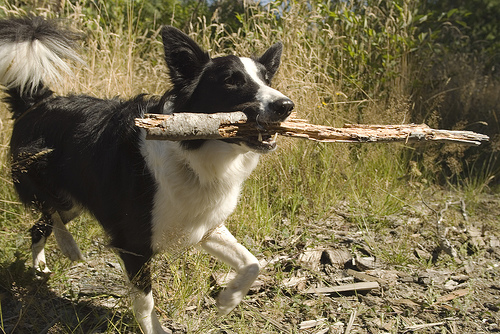

In [68]:

try_image = test_img[22]
Image.open(try_image)

In [69]:
print ('Normal search:', predict_captions(try_image))

Normal search: A black and white dog is running through a grassy area .


### MobileNet model with BLSTM

In [76]:
# define the captioning model
def define_model_2(vocab_size, max_len,embedding_size = 300):
    # feature extractor model
    inputs1 = Input(shape=(1024,))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = Bidirectional(LSTM(256,return_sequences=True))(se2)
    se4 = TimeDistributed(Dense(300))(se3)
    # decoder model
    main1 = Add()([fe2, se4])
    se4 = Dropout(0.2)(main1)
    BLSTM1 = Bidirectional(LSTM(256, return_sequences=True))(se4)
    print(BLSTM1.shape)
    BLSTM2 = Bidirectional(LSTM(256))(BLSTM1)
    decoder2 = Dense(256, activation='relu')(BLSTM2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy',  optimizer='RMSprop',metrics=['accuracy'])
    # summarize model
    model.summary()
    
    return model

In [77]:
Mobilenet_Blstm_model = define_model_2(8256,40)

(?, ?, 512)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      2476800     input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 40, 300)      0           embedding_2[0][0]                
_________________________________________________________________________________________________

In [ ]:
batch_size = 512

Mobilenet_Blstm_model.fit_generator(data_generator(batch_size), samples_per_epoch=(samples_per_epoch/batch_size), epochs=15, 
                          verbose=1)

D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=15, verbose=1, steps_per_epoch=748.933593...)`
  after removing the cwd from sys.path.


Epoch 1/15


In [ ]:
Mobilenet_Blstm_model.save_weights('Mobilenet_BLSTM_exp1_loss.h5')
from keras.models import load_model


Mobilenet_Blstm_model.save('Mobilenet_BLSTM_model.h5')


In [ ]:

Mobilenet_blstm_model_json = Mobilenet_Blstm_model.to_json()
with open("Mobilenet_blstm_model_json.json", "w") as json_file:
    json_file.write(Mobilenet_blstm_model_json)

In [ ]:

def predict_captions_2(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = Mobilenet_Blstm_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:

try_image = test_img[22]
Image.open(try_image)

In [ ]:
print ('Normal search:', predict_captions_2(try_image))

## Evaluation

The Flickr-8k dataset after preprocessing, provides data in the form of a dictionary where, the key is an image and the value for that image is a set of 5 captions. The BLEU metric is used to compare the predicted caption from the model to all the given caption labels. The best match from all these labels is picked as the final BLEU score.

In [54]:
#Import BLSTM model
from keras.models import load_model
BL_Mob_model = load_model('Mobilenet_BLSTM_model.h5')

In [70]:
#Import tokenizer
from nltk.tokenize import word_tokenize

In [71]:
#Predict captions for BLSTM
#Returns a dictionary with image and predicted caption
pred_dict = {}
for img in tqdm(test_img):
    pred_sent = predict_captions(img)
    pred_dict[img] = word_tokenize(pred_sent)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:20<00:00,  1.09it/s]


In [72]:
#Sentence bleu function to calculate bleu score
from nltk.translate.bleu_score import sentence_bleu


In [73]:
#Calculate BLEU for BLSTM
#Compares both dictionaries to give an output bleu score for each image
dict_map_2 = {}
for img in tqdm(pred_dict.keys()):
    predicted_sentence = pred_dict[img]
    sent_list = []
    for sent in test_d[img]:
        sent_list.append(word_tokenize(sent))
    #Check bleu
    #score = sentence_bleu(sent_list, predicted_sentence)
    score = sentence_bleu(sent_list, predicted_sentence, weights=(1, 0, 0, 0))
    dict_map_2[img] = score

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
D:\Applications\Anaconda\envs\tensorflow\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 842.82it/s]


In [74]:
#BLEU score is aggregated
blue_val = 0
for it in dict_map_2.values():
    blue_val = blue_val + it

In [75]:
#Converting to percentage
blue_val / 1000

0.5863787114423413

In [61]:
#Import LSTM model
from keras.models import load_model
L_Mob_model = load_model('Mobilenet_lstm_model.h5')

In [ ]:
#Predict captions for each image
pred_dict_2 = {}
for img in tqdm(test_img):
    pred_sent = predict_captions(img)
    pred_dict_2[img] = word_tokenize(pred_sent)

In [ ]:
#Calculate bleu score
dict_map = {}
for img in tqdm(pred_dict_2.keys()):
    predicted_sentence = pred_dict_2[img]
    sent_list = []
    for sent in test_d[img]:
        sent_list.append(word_tokenize(sent))
    #Check bleu
    #score = sentence_bleu(sent_list, predicted_sentence)
    score = sentence_bleu(sent_list, predicted_sentence, weights=(1, 0, 0, 0))
    dict_map[img] = score

In [ ]:
#Aggregate bleu score
bleu_val_2 = 0
for it in dict_map.values():
    bleu_val_2 = bleu_val_2 + it

In [ ]:
#Convert to percentage
bleu_val_2 / 1000

In [ ]:
#BLEU histogram for LSTM
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = dict_map.values()
plt.title("LSTM")
plt.hist(x, normed=True, bins=50)
plt.ylabel('BLEU');

In [ ]:
#BLEU histogram for BLSTM
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = dict_map_2.values()
plt.title("B-LSTM")
plt.hist(x, normed=True, bins=50)
plt.ylabel('BLEU');